# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from two_agents import Agents

In [2]:
from workspace_utils import active_session

k


In [3]:
#!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [16]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
agent = Agents(state_size=state_size, action_size=action_size, random_seed=123)

In [8]:
def maddpg_train(n_episodes=2500):
    
    scores_deque = deque(maxlen=100)
    scores = []
    ACC_SCORE = np.zeros(2)
    SHARE_EVERY = 50      # how many episodes to share weights from the better agent 
    noise_ratio = 1/1000  # cancels noise after 1000 episodes
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = 0
        t=0
        while True:
            noise = 1-(noise_ratio*i_episode) 
            actions = agent.act(states, noise=noise)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished                        
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.array(rewards)
            t+=1
            if np.any(dones):                                  # exit loop if episode finished
                break

        agent.prioritized_memory.beta += 0.001  # increment importance sampling wheights

        winner = np.argmax(score)
        ACC_SCORE[winner]+=1   
        
        if i_episode %  SHARE_EVERY == 0:
            final_winner = np.argmax(ACC_SCORE)
            agent.share_experince(final_winner)
            ACC_SCORE = np.zeros(2)
                
        scores_deque.append(max(score))
        scores.append(max(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tcurrent max score: {:.2f}\t time steps: {} '.format(i_episode, 
                                                            np.mean(scores_deque),max(score),t), end="")

        
        if np.mean(scores_deque)>=1.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
                                                            np.mean(scores_deque)))
            state_dicts = {
                              'a0'   :    agent.actors[0].state_dict(),
                              'at0'  :    agent.actors_target[0].state_dict(),
                              'a1'   :    agent.actors[1].state_dict(),
                              'at1'  :    agent.actors_target[1].state_dict(),
                              'c0'   :    agent.critics[0].state_dict(),
                              'ct0'  :    agent.critics_target[0].state_dict(),
                              'c1'   :    agent.critics[1].state_dict(),
                              'ct1'  :    agent.critics_target[1].state_dict()  }
            
            torch.save(state_dicts, 'checkpoint.pth')            

            break
    return scores


Episode 49	Average Score: 0.00	current max score: 0.00	 time steps: 15 
 0  shared to the other agent
Episode 99	Average Score: 0.00	current max score: 0.00	 time steps: 14 
 0  shared to the other agent
Episode 149	Average Score: 0.02	current max score: 0.00	 time steps: 14 
 1  shared to the other agent
Episode 199	Average Score: 0.02	current max score: 0.00	 time steps: 14 
 0  shared to the other agent
Episode 249	Average Score: 0.00	current max score: 0.00	 time steps: 14 
 0  shared to the other agent
Episode 299	Average Score: 0.00	current max score: 0.00	 time steps: 14 
 1  shared to the other agent
Episode 349	Average Score: 0.00	current max score: 0.00	 time steps: 14 
 0  shared to the other agent
Episode 399	Average Score: 0.01	current max score: 0.00	 time steps: 14 
 1  shared to the other agent
Episode 449	Average Score: 0.01	current max score: 0.10	 time steps: 41 
 0  shared to the other agent
Episode 499	Average Score: 0.04	current max score: 0.09	 time steps: 30 
 0

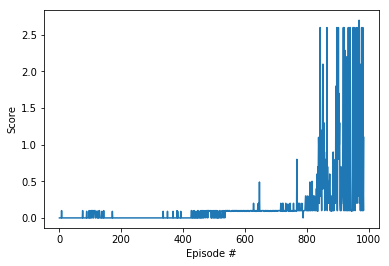

In [11]:
with active_session():
    scores = maddpg_train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## continue training
continue training for another 1000 episodes after modifying some numbers in the training function.

In [17]:
def maddpg_train2(n_episodes=2000):
    
    scores_deque = deque(maxlen=100)
    scores = []
    ACC_SCORE = np.zeros(2)
    SHARE_EVERY = 50      # how many episodes to share weights from the better agent 
    noise_ratio = 1/100  # cancels noise after 1000 episodes
    agent.prioritized_memory.beta = 1
    for i_episode in range(984, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = 0
        t=0
        while True:
            #noise = 1-(noise_ratio*i_episode) 
            noise = 0.05
            actions = agent.act(states, noise=noise)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished                        
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.array(rewards)
            t+=1
            if np.any(dones):                                  # exit loop if episode finished
                break

        #agent.prioritized_memory.beta += 0.001  # increment importance sampling wheights

        winner = np.argmax(score)
        ACC_SCORE[winner]+=1   
        
        if i_episode %  SHARE_EVERY == 0:
            final_winner = np.argmax(ACC_SCORE)
            agent.share_experince(final_winner)
            ACC_SCORE = np.zeros(2)

        scores_deque.append(max(score))
        scores.append(max(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tcurrent max score: {:.2f}\t time steps: {} '.format(i_episode, 
                                                            np.mean(scores_deque),max(score),t), end="")

        
        if np.mean(scores_deque)>=1.5 and len(scores_deque)==100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
                                                            np.mean(scores_deque)))
            state_dicts = {
                              'a0'   :    agent.actors[0].state_dict(),
                              'at0'  :    agent.actors_target[0].state_dict(),
                              'a1'   :    agent.actors[1].state_dict(),
                              'at1'  :    agent.actors_target[1].state_dict(),
                              'c0'   :    agent.critics[0].state_dict(),
                              'ct0'  :    agent.critics_target[0].state_dict(),
                              'c1'   :    agent.critics[1].state_dict(),
                              'ct1'  :    agent.critics_target[1].state_dict()  }
            
            torch.save(state_dicts, 'checkpoint2.pth')            

            break
    return scores


Episode 999	Average Score: 0.75	current max score: 1.10	 time steps: 428  
 0  shared to the other agent
Episode 1049	Average Score: 0.76	current max score: 2.60	 time steps: 1001 
 0  shared to the other agent
Episode 1099	Average Score: 0.85	current max score: 0.39	 time steps: 141  
 0  shared to the other agent
Episode 1149	Average Score: 1.03	current max score: 0.90	 time steps: 337  
 0  shared to the other agent
Episode 1199	Average Score: 0.88	current max score: 0.10	 time steps: 30   
 0  shared to the other agent
Episode 1249	Average Score: 0.39	current max score: 0.10	 time steps: 31  
 0  shared to the other agent
Episode 1299	Average Score: 0.29	current max score: 0.30	 time steps: 143 
 1  shared to the other agent
Episode 1349	Average Score: 0.55	current max score: 1.50	 time steps: 576  
 0  shared to the other agent
Episode 1399	Average Score: 0.85	current max score: 2.70	 time steps: 1001 
 0  shared to the other agent
Episode 1449	Average Score: 1.05	current max scor

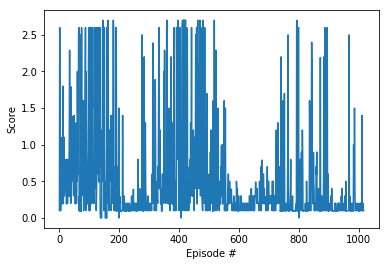

In [19]:
with active_session():
    scores2 = maddpg_train2(2000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores2)+1), scores2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [20]:
print(len(scores))
print(len(scores2))

984
1017


## Loading actors weights
Loading actors weights from saved models as they will be used in playing 

In [ ]:
checkpoint = torch.load('checkpoint.pth') 

In [ ]:
agent.actors[0].load_state_dict(checkpoint['a0'])
agent.actors[1].load_state_dict(checkpoint['a1'])